# Generative Adversarial Networks

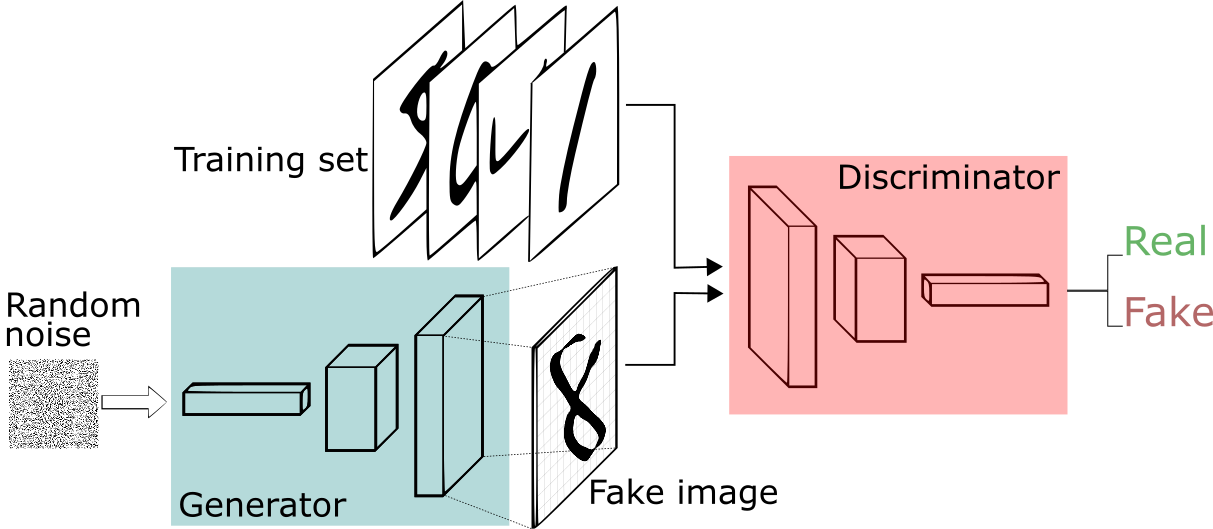

#### - Vanilla GAN => ONLY Fully Connected layers (2014)
#### - Deep Convolutional GAN (DCGAN) => Using CNN layers instead of FC (2015)
#### - Conditional GAN => Having one-hot encoding vector to decide what class to generate
#### - Wasserstein GAN => Small change of loss function
#### - Optimized WGAN => Gradient penalty
#### - Pix2Pix => Generate NOT from noise, BUT from another picture (change style => PAIRED)
#### - CycleGAN => Generate NOT from noise, BUT from another picture (change style => UNPAIRED)
#### - ProgressiveGAN
#### - Stacked GAN
#### - BigGAN (I'd say state-of-the-art)
#### Many others.....

# A bit of maths for Vanilla GAN

### Notation:
 - x is real sample
 - z is random noise (array of random numbers, usually size 100)
 - G(z) is output of generator given z as input
 - D(x) is output of discriminator given x as input
 - D(G(z)) is output of discriminator given G(z) as input


### The result of Discriminator is a probability (sigmoid function)
 - Ideally probability 1.0 when input is REAL
 - Ideally probability 0.0 when input is FAKE

### Discriminator => Maximize D(x) AND minimize D(G(z))

 $$maxL(\theta)= \frac{1}{m} \sum_{n=1}^m [ log(D(x^m)) + log(1 - D(G(z^m))) ]$$
 
### Generator => Maximize D(G(z))
 
 $$maxL(\theta)= \frac{1}{m} \sum_{n=1}^m log( D( G(z^m) ) )$$
 
 $$minL(\theta)= \frac{1}{m} \sum_{n=1}^m log( 1 - D( G(z^m) ) )$$
 
- The second formulation suffers from vanishing gradient when D is close to the optimal => we then max D(G(z))

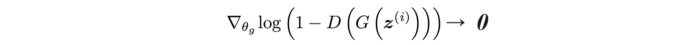


### I have to maximize these two losses => max f(x) == min - f(x) (Because TF only minimizes)

### Log loss heavily penalizes classifiers that are confident about an incorrect classification

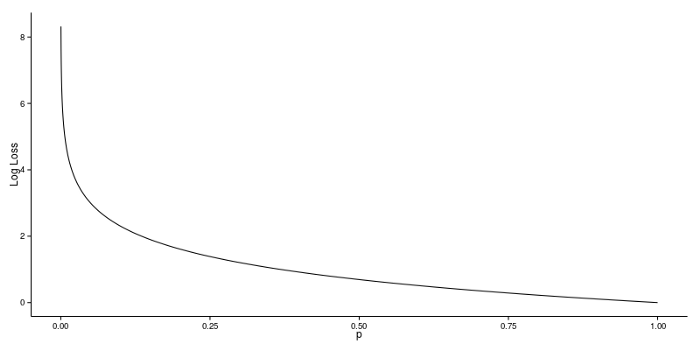

# Implementing a DCWGAN with gradient penalty

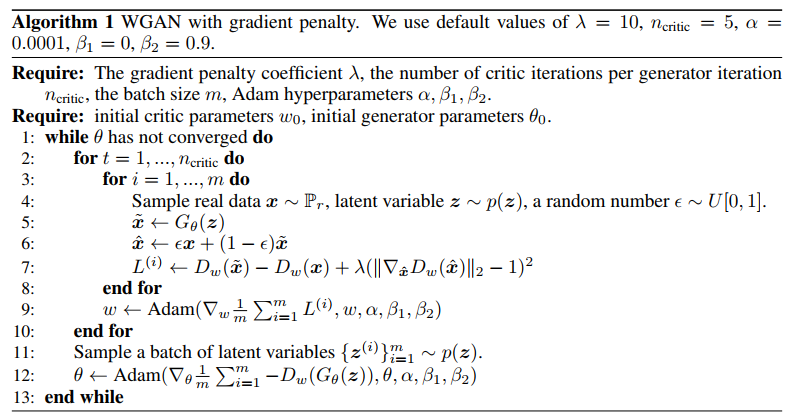

In [1]:
import numpy as np
import tensorflow as tf
import src.network as network
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# Working directory
base_path = "/home/francesco/UQ/Job/Tumour_GAN/"

# Parameters
epochs = 2000
batchSize = 64
lr = 1e-4
Z_dim = 100
lam = 10.0
num_D = 5
mu, sigma = 0, 1

## Loading data

In [3]:
def getDataTumour(path, value="mel", resize=None):
    DF = pd.read_pickle(path)
    assert(len(DF["image"]) == len(DF["id"]))
    
    X = []
    for i in range(len(DF["image"])):
        
        if DF["id"][i] == value:
            if resize is None:
                X.append(DF["image"][i])
            else:
                tmp = cv2.resize(DF["image"][i], resize, interpolation = cv2.INTER_CUBIC)
                X.append(tmp)
                
    return np.array(X, dtype=np.float32)


def normalize(vector, a, b, max_val=255, min_val=0):
    assert(a < b)
    print("MAX : " + str(vector.max()) + " and MIN: " + str(vector.min()))

    #result = (b - a) * ( (vector - min_val) / (max_val - min_val) ) + a
    result = (vector - 127.5) / 127.5

    print("Normalized MAX : " + str(result.max()) + " and MIN: " + str(result.min()))
    return result


# Load and normalize data
H, W = int(128), int(128)
X_train = getDataTumour(base_path + "data/NvAndMelFullSizeTest.pkl", value="nv", resize=(W, H))
print(X_train.shape)
X_train = normalize(X_train, -1.0, 1.0)

(200, 128, 128, 3)
MAX : 255.0 and MIN: 0.0
Normalized MAX : 1.0 and MIN: -1.0


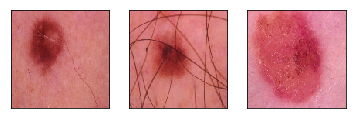

In [6]:
fig, axes = plt.subplots(1, 3)

for i, ax in enumerate(axes.flat):
    ax.imshow(( (X_train[i] * 127.5) + 127.5 ).astype(np.uint8))            
    ax.set_xticks([])
    ax.set_yticks([])

# Tensorflow

In [7]:
# Inputs
tf.reset_default_graph()

def generator():
    for el in X_train:
        yield el

# Create Tensorflow data generator
dataset = tf.data.Dataset.from_generator(generator,
                                         (tf.float32),
                                         output_shapes=(tf.TensorShape([H, W, 3])))

dataset = dataset.repeat(epochs).shuffle(buffer_size=len(X_train)).batch(batchSize, drop_remainder=True)
iterator = dataset.make_one_shot_iterator()
X = iterator.get_next()
batchSizeTensor = tf.placeholder(tf.int32)
Z = network.sample_noise(batchSizeTensor, Z_dim)
isTraining = tf.placeholder(dtype=tf.bool)

# Networks
G_z = network.generator(Z, isTraining)
D_logits_real = network.discriminator(X)
D_logits_fake = network.discriminator(G_z, reuse=True)

Tensor("random_normal:0", shape=(?, 100), dtype=float32)
Tensor("generator/LeakyRelu:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("generator/LeakyRelu_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("generator/LeakyRelu_2:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("generator/LeakyRelu_3:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("generator/LeakyRelu_4:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("generator/Tanh:0", shape=(?, 128, 128, 3), dtype=float32)

Tensor("IteratorGetNext:0", shape=(64, 128, 128, 3), dtype=float32)
Tensor("discriminator/LeakyRelu:0", shape=(64, 64, 64, 64), dtype=float32)
Tensor("discriminator/LeakyRelu_1:0", shape=(64, 32, 32, 128), dtype=float32)
Tensor("discriminator/LeakyRelu_2:0", shape=(64, 16, 16, 256), dtype=float32)
Tensor("discriminator/LeakyRelu_3:0", shape=(64, 8, 8, 512), dtype=float32)
Tensor("discriminator/LeakyRelu_4:0", shape=(64, 4, 4, 1024), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(64, 1), dtype=floa

In [8]:
def WGAN_Loss(D_logits_real, D_logits_fake, grad_penalty):
    D_loss = tf.reduce_mean(D_logits_fake) - tf.reduce_mean(D_logits_real) + grad_penalty
    G_loss = - tf.reduce_mean(D_logits_fake)

    return D_loss, G_loss


def WGAN_Optimizer(D_loss, G_loss, lr):
    D_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]
    G_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        D_optimizer = tf.train.AdamOptimizer(lr, 0.5, 0.9).minimize(D_loss, var_list=D_vars)
        G_optimizer = tf.train.AdamOptimizer(lr, 0.5, 0.9).minimize(G_loss, var_list=G_vars)

    return D_optimizer, G_optimizer

# Compute gradient penalty
eps = tf.random_uniform([batchSizeTensor, 1, 1, 1], minval=0., maxval=1.)
X_inter = eps * X + (1. - eps) * G_z
grad = tf.gradients(network.discriminator(X_inter, reuse=True), [X_inter])[0]
gradients = tf.sqrt(tf.reduce_sum(tf.square(grad), [1, 2, 3]))
grad_penalty = lam * tf.reduce_mean(tf.square(gradients - 1))

# Losses and optimizer
D_loss, G_loss, = WGAN_Loss(D_logits_real, D_logits_fake, grad_penalty)
D_optimizer, G_optimizer = WGAN_Optimizer(D_loss, G_loss, lr)

Instructions for updating:
Use tf.cast instead.


In [9]:
# Tensorboard
summaries_dir = base_path + "checkpoints"

# Summaries | VISUALIZE => tensorboard --logdir=.
tf.summary.scalar('D_loss', -D_loss)
tf.summary.scalar('G_loss', G_loss)

merged_summary = tf.summary.merge_all()

In [ ]:
with tf.Session() as sess:
    saver = tf.train.Saver(max_to_keep=1000)
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter(summaries_dir, graph=tf.get_default_graph())
    
    globalStep = 0
    try: 
        while True:

            # Train discriminator (more at the beginning)
            D_iterations = 30 if (globalStep < 5 or globalStep % 500 == 0) else num_D
            for _ in range(D_iterations):
                sess.run(D_optimizer, feed_dict={ isTraining: True, batchSizeTensor : batchSize })

            # Train generator
            sess.run(G_optimizer, feed_dict={ isTraining: True, batchSizeTensor : batchSize })

            # Save summary
            if globalStep % 20 == 0:
                summary = sess.run(merged_summ, feed_dict={ isTraining: True, batchSizeTensor : batchSize })
                summary_writer.add_summary(summary, globalStep)

            # Save checkpoints and images
            if globalStep % 100 == 0:
                save_path = saver.save(sess, base_path + "checkpoints/model-" + str(globalStep) + ".ckpt")
                G_output = sess.run(G_z, feed_dict={ isTraining : False, batchSizeTensor : 5 })
                util.saveImages(base_path + "images/out-" + str(globalStep), G_output)

            globalStep += 1
            
    except tf.errors.OutOfRangeError:
        pass

# Generate new samples

Tensor("random_normal:0", shape=(?, 100), dtype=float32)
Tensor("generator/LeakyRelu:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("generator/LeakyRelu_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("generator/LeakyRelu_2:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("generator/LeakyRelu_3:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("generator/LeakyRelu_4:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("generator/Tanh:0", shape=(?, 128, 128, 3), dtype=float32)

INFO:tensorflow:Restoring parameters from /home/francesco/UQ/Job/Tumour_GAN/CHECKPOINTS_WDCGAN128/model-33400.ckpt


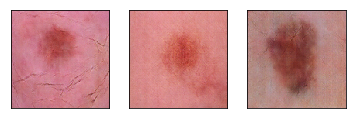

In [12]:
tf.reset_default_graph()

batchSizeTensor = tf.placeholder(tf.int32)
Z = network.sample_noise(batchSizeTensor, Z_dim)
isTraining = tf.placeholder(dtype=tf.bool)
G_z = network.generator(Z, isTraining)

with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, base_path + "CHECKPOINTS_WDCGAN128/model-33400.ckpt")

    images = []
    for j in range(3):
        G_output = sess.run(G_z, feed_dict={ isTraining : False, batchSizeTensor : 1 })
        images.append(G_output[0])
    
    fig, axes = plt.subplots(1, 3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(( (images[i] * 127.5) + 127.5 ).astype(np.uint8))            
        ax.set_xticks([])
        ax.set_yticks([])